In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/resnet-parameter/resnet10_cifar10.pt
/kaggle/input/resnet-parameter/resnet/resnet10_cifar10.pt
/kaggle/input/resnet-parameter/resnet/data/cifar-10-batches-py/data_batch_1
/kaggle/input/resnet-parameter/resnet/data/cifar-10-batches-py/data_batch_2
/kaggle/input/resnet-parameter/resnet/data/cifar-10-batches-py/batches.meta
/kaggle/input/resnet-parameter/resnet/data/cifar-10-batches-py/test_batch
/kaggle/input/resnet-parameter/resnet/data/cifar-10-batches-py/data_batch_3
/kaggle/input/resnet-parameter/resnet/data/cifar-10-batches-py/data_batch_5
/kaggle/input/resnet-parameter/resnet/data/cifar-10-batches-py/data_batch_4
/kaggle/input/resnet-parameter/resnet/data/cifar-10-batches-py/readme.html
/kaggle/input/resnet-parameter/resnet/data/cifar-10-python/cifar-10-batches-py/data_batch_1
/kaggle/input/resnet-parameter/resnet/data/cifar-10-python/cifar-10-batches-py/data_batch_2
/kaggle/input/resnet-parameter/resnet/data/cifar-10-python/cifar-10-batches-py/batches.meta
/kaggle/in

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [3]:
class Bottleneck(nn.Module):
    expansion = 4
    def __init__(self, in_channels, out_channels, i_downsample=None, stride=1):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, padding=0)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.conv3 = nn.Conv2d(out_channels, out_channels*self.expansion, kernel_size=1, stride=1, padding=0)
        self.bn3 = nn.BatchNorm2d(out_channels*self.expansion)
        
        self.i_downsample = i_downsample
        self.stride = stride
        self.relu = nn.ReLU()
    
    def forward(self, x):
        identify = x.clone()
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.relu(self.bn2(self.conv2(x)))
        x = self.bn3(self.conv3(x))
        if self.i_downsample:
            identify = self.i_downsample(identify)
        x = self.relu(x+identify)
        return x

class Block(nn.Module):
    expansion = 4
    def __init__(self, in_channels, out_channels, i_downsample=None, stride=1):
        super(Block, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, stride=stride, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels*self.expansion, kernel_size=3, padding=1, stride=stride, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels*self.expansion)

        
        self.i_downsample = i_downsample
        self.stride = stride
        self.relu = nn.ReLU()
    
    def forward(self, x):
        identify = x.clone()
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.bn2(self.conv2(x))
        if self.i_downsample:
            identify = self.i_downsample(identify)
        x = self.relu(x+identify)
        return x

class ResNet(nn.Module):
    def __init__(self, ResBlock, in_channels, layer_list, num_classes, num_channels=3, stride=2):
        super(ResNet, self).__init__()
        self.in_channels = in_channels
        self.conv1 = nn.Conv2d(num_channels, in_channels, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(in_channels)
        self.relu = nn.ReLU()
        self.max_pooling = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        
        self.layer1 = self._make_layer(ResBlock, layer_list[0], planes=64)
        self.layer2 = self._make_layer(ResBlock, layer_list[1], planes=128, stride=stride)
        self.layer3 = self._make_layer(ResBlock, layer_list[2], planes=256, stride=stride)
        self.layer4 = self._make_layer(ResBlock, layer_list[3], planes=512, stride=stride)
        
        self.avgpool = nn.AdaptiveAvgPool2d((1,1))
        self.fc = nn.Linear(512*ResBlock.expansion, num_classes)
        
    def forward(self, x):
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.max_pooling(x)
        
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.avgpool(x)
        x = x.reshape(x.shape[0], -1)
        x = self.fc(x)
        return x
    
    def _make_layer(self, ResBlock, num_blocks, planes, stride=1):
        ii_downsample = None
        layers = []
        if stride != 1 or self.in_channels != planes * ResBlock.expansion:
            ii_downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, planes * ResBlock.expansion, kernel_size=1, stride=stride),
                nn.BatchNorm2d(planes * ResBlock.expansion)
            ) 
            
        layers.append(ResBlock(self.in_channels, planes, ii_downsample, stride))
        self.in_channels = planes * ResBlock.expansion
        for i in range(num_blocks-1):
            layers.append(ResBlock(self.in_channels, planes))
        return nn.Sequential(*layers)
    
def ResNet18(num_classes, channels=3):
    return ResNet(Block, 64, [2, 2, 2, 2], num_classes, channels, 1)
    
def ResNet50(num_classes, channels=3):
    return ResNet(Bottleneck, 64, [3, 4, 6, 3], num_classes, channels, 2)

def ResNet101(num_classes, channels=3):
    return ResNet(Bottleneck, 64, [3, 4, 23, 3], num_classes, channels, 2)

def ResNet152(num_classes, channels=3):
    return ResNet(Bottleneck, 64, [3, 8, 36, 3], num_classes, channels, 2)

In [4]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


In [5]:
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])
train = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)

trainloader = torch.utils.data.DataLoader(train, batch_size=128, shuffle=True, num_workers=2)

test = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

testloader = torch.utils.data.DataLoader(test, batch_size=128,shuffle=False, num_workers=2)

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


100%|██████████| 170498071/170498071 [00:12<00:00, 14192610.85it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [6]:
model = ResNet18(10).to('cuda')
# model.load_state_dict(torch.load("/kaggle/input/resnet-parameter/resnet/resnet10_cifar10.pt", weights_only=True))
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=0.0001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor = 0.1, patience=5)

In [7]:
epochs = 100
for epoch in range(epochs):
    losses = []
    running_loss = 0
    for i, inp in enumerate(trainloader):
        inputs, labels = inp
#         print(inputs.shape)
        inputs, labels = inputs.to('cuda'), labels.to('cuda')
        optimizer.zero_grad()
    
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        losses.append(loss.item())

        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
    if epoch%(epochs//10) == 0:
        print(f'Loss [{epoch}](epoch): ', running_loss / len(trainloader))
        running_loss = 0.0

    avg_loss = sum(losses)/len(losses)
    scheduler.step(avg_loss)
            
print('Training Done')
torch.save(model.state_dict(), "resnet50_cifar10.pt")

Loss [0](epoch):  2.7968936673820477
Loss [10](epoch):  0.8199350873527624
Loss [20](epoch):  0.5149056553993079
Loss [30](epoch):  0.378554533395316
Loss [40](epoch):  0.2949206956359736
Loss [50](epoch):  0.2437639180237375
Loss [60](epoch):  0.20793118177320036
Loss [70](epoch):  0.1845861225939163
Loss [80](epoch):  0.1707509790482881
Loss [90](epoch):  0.14983631320812207
Training Done


In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
# model.load_state_dict(torch.load("/kaggle/input/resnet-parameter/resnet10_cifar10.pt", weights_only=True))
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to('cuda'), labels.to('cuda')
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

all_preds = np.array(all_preds)
all_labels = np.array(all_labels)
cm = confusion_matrix(all_labels, all_preds)


In [9]:
from sklearn.metrics import accuracy_score, f1_score
accuracy = accuracy_score(all_labels, all_preds)
f1_macro = f1_score(all_labels, all_preds, average='macro')
print("Accuracy: ", accuracy)
print("F1 score: ", f1_macro)

Accuracy:  0.8409
F1 score:  0.8399030778188108


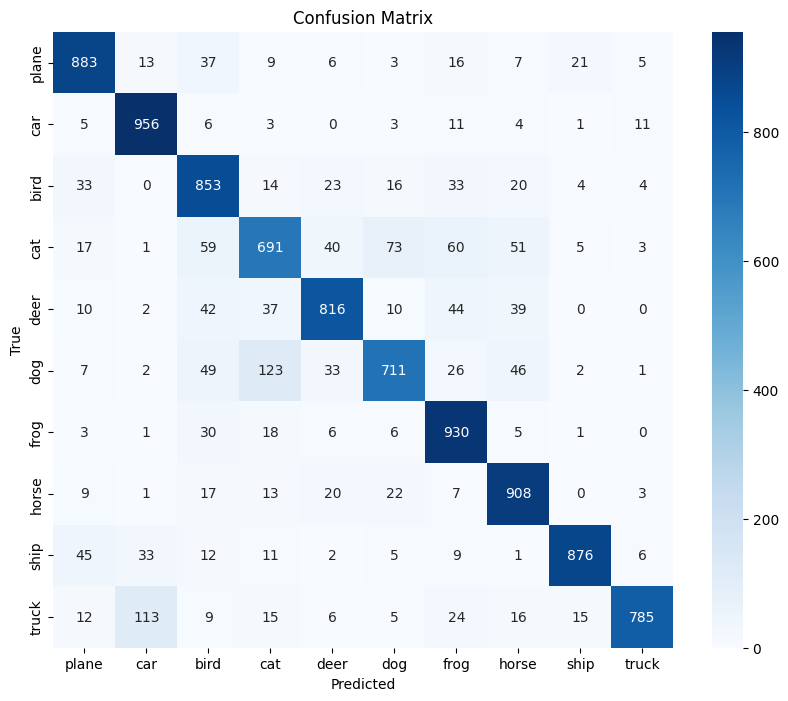

In [10]:
class_names = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()